# Profiling tiling of titiler-pgstac and titiler-xarray

This notebook profiles code for tiling CMIP6 data via 2 methods:

1. pgSTAC + COGs: The first method uses a (local or remote) pgSTAC database for storing metadata about COGs on S3. The libraries used are pgstac for reading STAC metadata and rio_tiler's rasterio for reading COGs on S3.
2. kerchunk + netCDF: The second method uses a (local or S3) kerchunk reference file for NetCDF files stored on S3. The libraries used are xarray for reading the Zarr metadata and rio_tiler's XarrayReader for reading data from the NetCDFs on S3.
3. Zarr stores with different chunking configurations.

In the future, the following improvements and additions to this profiling code will be made:

1. Test zarr stores with pyramids
2. Test different tiles + sum the results.
3. Test a higher resolution dataset.

## Setup / Step 0

1. Load some basic libraries
2. Set an initial tile to test
3. Add some AWS credentials
4. Install any missing libraries

In [1]:
%load_ext autoreload
%autoreload

import boto3
from datetime import datetime
import io
from PIL import Image
import os
import warnings
import cmip6_zarr.eodc_hub_role
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from profiler.main import Timer, cprofile_list_to_dict

from cmip6_zarr import eodc_hub_role
credentials = eodc_hub_role.fetch_and_set_credentials()
os.environ['AWS_ACCESS_KEY_ID'] = credentials['AccessKeyId']
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials['SecretAccessKey']
os.environ['AWS_SESSION_TOKEN'] = credentials['SessionToken'] 
import cmip6_pgstac.profile_pgstac as profile_pgstac

warnings.filterwarnings('ignore')

Caught exception: An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 34.220.42.38/32, TCP, from port: 5432, to port: 5432, ALLOW" already exists
Connected to database


In [ ]:
#!pip install morecantile==3.4.0 loguru titiler titiler-pgstac
#!pip install psycopg psycopg_binary psycopg_pool

In [2]:
%%capture
!pip install -r requirements.txt

In [3]:
# import morecantile
# tms = morecantile.tms.get("WebMercatorQuad")
# tile = tms.tile(-73.97, 40.78, 8)
# xyz_tile = (tile.x, tile.y, tile.z)
xyz_tile = (0, 0, 0)

In [4]:
#parameters
temporal_resolution = "daily"
model = "GISS-E2-1-G"
variable = "tas"
anon=True

## Profile titiler-pgstac

To achieve the best performance, we set some GDAL environment variables.

These variables are documented here https://developmentseed.org/titiler/advanced/performance_tuning/, but that advice is copied into comments below for ease of reference.

In [5]:
gdal_env_vars = {
    # By default GDAL reads the first 16KB of the file, then if that doesn't contain the entire metadata
    # it makes one more request for the rest of the metadata.
    # In environments where latency is relatively high, AWS S3,
    # it may be beneficial to increase this value depending on the data you expect to read.    
    'GDAL_INGESTED_BYTES_AT_OPEN': '32768',
    # It's much better to set EMPTY_DIR because this prevents GDAL from making a LIST request.
    # LIST requests are made for sidecar files, which does not apply for COGs    
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    # Tells GDAL to merge consecutive range GET requests.    
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES',
    # When set to YES, this attempts to download multiple range requests in parallel, reusing the same TCP connection. 
    # Note this is only possible when the server supports HTTP2, which many servers don't yet support.
    # There's no downside to setting YES here.    
    'GDAL_HTTP_MULTIPLEX': 'YES',
    'GDAL_HTTP_VERSION': '2',
    # Setting this to TRUE enables GDAL to use an internal caching mechanism. It's recommended (strongly).    
    'VSI_CACHE': 'TRUE'
}

def set_or_unset_gdal(set_vars=True):
    if set_vars:
        for key, value in gdal_env_vars.items():
            os.environ[key] = value
    else:
        for key, value in gdal_env_vars.items():
            os.environ.pop(key, None)
    return

In [6]:
if temporal_resolution == 'daily':
    collection = f"CMIP6_daily_{model}_{variable}"
elif temporal_resolution == 'monthly':
    collection = f"CMIP6_ensemble_monthly_median_{variable}"

niters = 10
cog_results_df = {
    'with_gdal_vars': {
        'total time': [],
        'mean total time': None
    },
    'without_gdal_vars': {
        'total time': [],
        'mean total time': None
    },
}
query = {
  "collections": [ collection ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z"           
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

for settings in ['with_gdal_vars', 'without_gdal_vars']:
    results_timings = cog_results_df[settings]
    if settings == 'with_gdal_vars':
        set_or_unset_gdal(set_vars=True)
    else:
        set_or_unset_gdal(set_vars=False)
    for iter in range(niters):
        with Timer() as t:
            image_and_assets, cprofile = profile_pgstac.tile(*xyz_tile, query=dict(query))
        results_timings['total time'].append(round(t.elapsed * 1000, 2))
    results_timings['mean total time'] = np.mean(results_timings['total time'])
    

{'pgstac-search': 36.19, 'get_tile': [262.42], 'mosaic': 263.28}
{'pgstac-search': 0.32, 'get_tile': [39.97], 'mosaic': 40.56}
{'pgstac-search': 0.31, 'get_tile': [32.51], 'mosaic': 33.05}
{'pgstac-search': 0.29, 'get_tile': [32.67], 'mosaic': 33.19}
{'pgstac-search': 0.29, 'get_tile': [33.44], 'mosaic': 33.97}
{'pgstac-search': 0.29, 'get_tile': [32.65], 'mosaic': 33.15}
{'pgstac-search': 0.29, 'get_tile': [32.63], 'mosaic': 33.14}
{'pgstac-search': 0.28, 'get_tile': [31.99], 'mosaic': 32.5}
{'pgstac-search': 0.28, 'get_tile': [33.13], 'mosaic': 33.63}
{'pgstac-search': 0.28, 'get_tile': [32.03], 'mosaic': 32.52}
{'pgstac-search': 0.38, 'get_tile': [16772.0], 'mosaic': 16772.98}
{'pgstac-search': 0.38, 'get_tile': [29758.88], 'mosaic': 29759.92}
{'pgstac-search': 0.39, 'get_tile': [27854.3], 'mosaic': 27855.63}
{'pgstac-search': 0.38, 'get_tile': [26239.39], 'mosaic': 26240.33}
{'pgstac-search': 0.37, 'get_tile': [28257.87], 'mosaic': 28259.54}
{'pgstac-search': 0.39, 'get_tile': [155

In [7]:
pd.DataFrame.from_dict(cog_results_df, orient='index')

,total time,mean total time
with_gdal_vars,"[318.35, 54.98, 48.23, 42.26, 44.13, 41.93, 41...",71.584
without_gdal_vars,"[16782.94, 29770.21, 27866.86, 26250.64, 28269...",23109.038


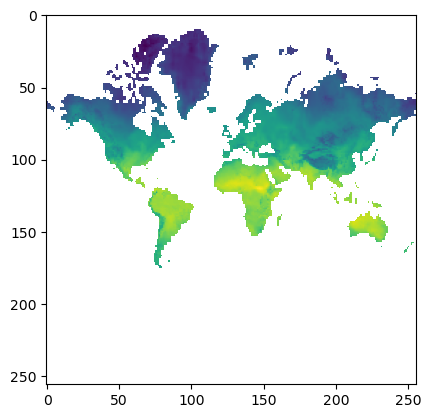

In [8]:
image = image_and_assets[0].data_as_image()
imshow(image)

# Profile titiler-xarray

In [9]:
# useful to always reload the module while its being developed
%load_ext autoreload
%autoreload
import xarray_tile_reader
import zarr_reader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
bucket = 'nasa-eodc-data-store'
chunk_set_paths = ['600_1440_1', '600_1440_29', '365_262_262']
results_df = {
  'kerchunk': {
      "data_store_path": f"combined_CMIP6_{temporal_resolution}_{model}_{variable}_kerchunk.json"
  }
}

for chunk_set_path in chunk_set_paths:
    results_df[chunk_set_path] = {
        'data_store_path': f"{chunk_set_path}/CMIP6_{temporal_resolution}_{model}_{variable}.zarr"
    }

In [11]:
niters = 10

for dataset in results_df.keys():
    data_store_path = results_df[dataset]['data_store_path']
    data_store_url = f"s3://{bucket}/{data_store_path}"
    reference = False
    if dataset == 'kerchunk':
        reference = True

    ds = zarr_reader.xarray_open_dataset(data_store_url, anon=False, reference=reference)

    dask_array = ds[0][variable]
    chunk_size_bytes = dask_array.dtype.itemsize * dask_array.chunks[0][0] * dask_array.chunks[1][0] * dask_array.chunks[2][0]
    chunk_size_mb = chunk_size_bytes / (1024 * 1024)
    results_df[dataset]['chunk_size_mb'] = chunk_size_mb
    results_df[dataset]['timings'] = {
        'time to open (ms)': [],
        'rio reproject (ms)': [],
        'total time (ms)': [],
    }
    timings_results = results_df[dataset]['timings']
    for iter in range(niters):
        with Timer() as t:
            image_and_timings, cprofile = xarray_tile_reader.tile(
                data_store_url,
                *xyz_tile,
                reference=reference,
                anon=False,
                variable=variable,
            )
        total_time = round(t.elapsed * 1000, 2)

        timings = image_and_timings[1]
        timings_results['time to open (ms)'].append(timings['time_to_open']),
        timings_results['rio reproject (ms)'].append(timings['rio.reproject']),
        timings_results['total time (ms)'].append(total_time)
    results_df[dataset]['mean time to open (ms)'] = np.mean(timings_results['time to open (ms)'])
    results_df[dataset]['mean rio reproject (ms)'] = np.mean(timings_results['rio reproject (ms)']) 
    results_df[dataset]['mean total time (ms)'] = np.mean(timings_results['total time (ms)'])

In [12]:
df = pd.DataFrame.from_dict(results_df, orient='index')
df.drop(columns=['timings']).sort_values('mean total time (ms)')

,data_store_path,chunk_size_mb,mean time to open (ms),mean rio reproject (ms),mean total time (ms)
kerchunk,combined_CMIP6_daily_GISS-E2-1-G_tas_kerchunk....,3.295898,59.453,137.165,266.826
600_1440_29,600_1440_29/CMIP6_daily_GISS-E2-1-G_tas.zarr,95.581055,122.886,565.691,779.547
365_262_262,365_262_262/CMIP6_daily_GISS-E2-1-G_tas.zarr,95.577469,89.448,1283.191,1463.516
600_1440_1,600_1440_1/CMIP6_daily_GISS-E2-1-G_tas.zarr,3.295898,1619.619,77.588,1766.349
